<a href="https://colab.research.google.com/github/farrelrassya/IntroductionMachineLearningwithpython/blob/main/05.model_evaluation_and_improvement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Evaluation and Improvement

Having discussed the fundamentals of supervised and unsupervised learning, and having explored a variety of machine learning algorithms, we will now dive more deeply into evaluating models and selecting parameters.

We will focus on the supervised methods, regression and classification, as evaluating and selecting models in unsupervised learning is often a very qualitative process (as we saw in Chapter 3).

To evaluate our supervised models, so far we have split our dataset into a training set and a test set using the `train_test_split` function, built a model on the training set by calling the `fit` method, and evaluated it on the test set using the `score` method, which for classification computes the fraction of correctly classified samples. The classification accuracy is defined as:

$$\text{Accuracy} = \frac{1}{n_{\text{test}}} \sum_{i=1}^{n_{\text{test}}} \mathbf{1}[\hat{y}_i = y_i]$$

where $\mathbf{1}[\cdot]$ is the indicator function that equals 1 when the prediction $\hat{y}_i$ matches the true label $y_i$. Here's an example of that process:

## Setup

In [1]:
!pip install -q mglearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.4/581.4 kB 12.9 MB/s eta 0:00:00


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mglearn
import warnings
warnings.filterwarnings('ignore')


# Patch mglearn.tools.heatmap for numpy/matplotlib compatibility
# (fixes "Only length-1 arrays can be converted to Python scalars" error)
import mglearn.tools as _mt
def _patched_heatmap(values, xlabel, ylabel, xticklabels, yticklabels,
                     cmap=None, vmin=None, vmax=None, ax=None, fmt="%0.2f"):
    if ax is None:
        ax = plt.gca()
    values = np.array(values, dtype=np.float64)
    img = ax.pcolor(values, cmap=cmap, vmin=vmin, vmax=vmax)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)
    for p, color, value in zip(img.get_paths(), img.get_facecolors(),
                               values.ravel()):
        x, y = p.vertices[:-2, :].mean(0)
        c = 'k' if np.mean(color[:3]) > 0.5 else 'w'
        ax.text(x, y, fmt % float(value), color=c, ha="center", va="center")
    return img
_mt.heatmap = _patched_heatmap

In [3]:
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# create a synthetic dataset
X, y = make_blobs(random_state=0)
# split data and labels into a training and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
# instantiate a model and fit it to the training set
logreg = LogisticRegression().fit(X_train, y_train)
# evaluate the model on the test set
print("Test set score: {:.2f}".format(logreg.score(X_test, y_test)))

Test set score: 0.88


The logistic regression achieves 88% accuracy on this synthetic three-class blob dataset. This is a decent result, but it depends on the particular random split -- a different `random_state` could give a very different number. Remember, the reason we split our data into training and test sets is that we are interested in measuring how well our model **generalizes** to new, previously unseen data. We are not interested in how well our model fit the training set, but rather in how well it can make predictions for data that was not observed during training.

In this chapter, we will expand on two aspects of this evaluation. We will first introduce **cross-validation**, a more robust way to assess generalization performance, and discuss methods to evaluate classification and regression performance that go beyond the default measures of accuracy and $R^2$ provided by the `score` method. We will also discuss **grid search**, an effective method for adjusting the parameters in supervised models for the best generalization performance.

## Cross-Validation

Cross-validation is a statistical method of evaluating generalization performance that is more stable and thorough than using a split into a training and a test set. In cross-validation, the data is instead split repeatedly and multiple models are trained. The most commonly used version of cross-validation is **$k$-fold cross-validation**, where $k$ is a user-specified number, usually 5 or 10. When performing five-fold cross-validation, the data is first partitioned into five parts of (approximately) equal size, called **folds**. Next, a sequence of models is trained. The first model is trained using the first fold as the test set, and the remaining folds (2-5) are used as the training set. The model is built using the data in folds 2-5, and then the accuracy is evaluated on fold 1. Then another model is built, this time using fold 2 as the test set and the data in folds 1, 3, 4, and 5 as the training set. This process is repeated using folds 3, 4, and 5 as test sets.

For each of these $k$ splits of the data into training and test sets, we compute the accuracy. In the end, we have collected $k$ accuracy values:

$$\text{CV Score} = \frac{1}{k} \sum_{i=1}^{k} \text{Accuracy}_i$$

The process is illustrated in the following figure. Usually, the first fifth of the data is the first fold, the second fifth of the data is the second fold, and so on:

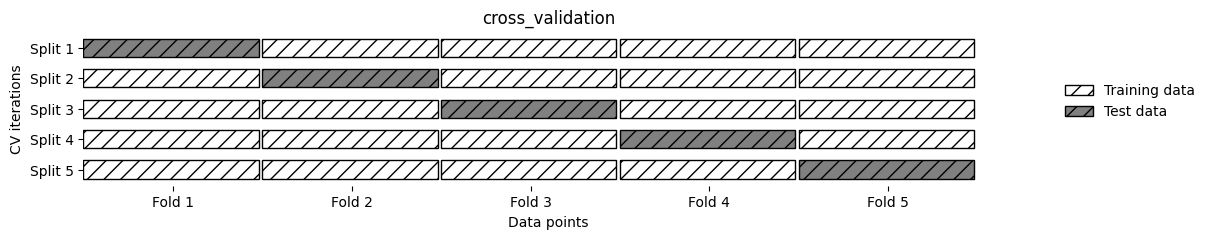

In [4]:
mglearn.plots.plot_cross_validation()

### Cross-Validation in scikit-learn

Cross-validation is implemented in scikit-learn using the `cross_val_score` function from the `model_selection` module. The parameters of the `cross_val_score` function are the model we want to evaluate, the training data, and the ground-truth labels. Let's evaluate `LogisticRegression` on the iris dataset:

In [5]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

iris = load_iris()
logreg = LogisticRegression(max_iter=1000)

scores = cross_val_score(logreg, iris.data, iris.target, cv=5)
print("Cross-validation scores: {}".format(scores))

Cross-validation scores: [0.96666667 1.         0.93333333 0.96666667 1.        ]


By default, `cross_val_score` performs five-fold stratified cross-validation for classification, returning five accuracy values. A common way to summarize the cross-validation accuracy is to compute the mean:

In [6]:
print("Average cross-validation score: {:.2f}".format(scores.mean()))

Average cross-validation score: 0.97


Using the mean cross-validation we can conclude that we expect the model to be around 97% accurate on average. Looking at all five scores produced by the five-fold cross-validation, we can also conclude that there is a relatively high variance in the accuracy between folds, ranging from 100% accuracy to 93% accuracy. This could imply that the model is very dependent on the particular folds used for training, but it could also just be a consequence of the small size of the dataset (only 150 samples total, so each fold has about 30 samples).

Formally, for the five-fold cross-validation above, the standard deviation of the scores gives a sense of the spread:

$$\sigma = \sqrt{\frac{1}{k} \sum_{i=1}^{k} \left( \text{Accuracy}_i - \overline{\text{Accuracy}} \right)^2}$$

### Benefits of Cross-Validation

There are several benefits to using cross-validation instead of a single split into a training and a test set. First, remember that `train_test_split` performs a random split of the data. Imagine that we are "lucky" when randomly splitting the data, and all examples that are hard to classify end up in the training set. In that case, the test set will only contain "easy" examples, and our test set accuracy will be unrealistically high. Conversely, if we are "unlucky," we might have randomly put all the hard-to-classify examples in the test set and consequently obtain an unrealistically low score. However, when using cross-validation, each example will be in the training set exactly $k - 1$ times and in the test set exactly once. Therefore, the model needs to generalize well to all of the samples in the dataset for all of the cross-validation scores (and their mean) to be high.

Having multiple splits of the data also provides some information about how sensitive our model is to the selection of the training dataset. For the iris dataset, we saw accuracies between 93% and 100%. This is quite a range, and it provides us with an idea about how the model might perform in the worst case and best case scenarios when applied to new data.

Another benefit of cross-validation as compared to using a single split of the data is that we use our data more effectively. When using `train_test_split`, we usually use 75% of the data for training and 25% of the data for evaluation. When using five-fold cross-validation, in each iteration we can use $\frac{k-1}{k} = \frac{4}{5} = 80\%$ of the data to fit the model. When using 10-fold cross-validation, we can use $\frac{9}{10} = 90\%$ of the data to fit the model. More data will usually result in more accurate models.

The main disadvantage of cross-validation is increased computational cost. As we are now training $k$ models instead of a single model, cross-validation will be roughly $k$ times slower than doing a single split of the data.

> **Important:** Cross-validation is not a way to build a model that can be applied to new data. Cross-validation does not return a model. When calling `cross_val_score`, multiple models are built internally, but the purpose of cross-validation is only to evaluate how well a given algorithm will generalize when trained on a specific dataset.

### Stratified $k$-Fold Cross-Validation and Other Strategies

Splitting the dataset into $k$ folds by starting with the first one-$k$-th part of the data, as described in the previous section, might not always be a good idea. For example, let's have a look at the iris dataset:

In [7]:
from sklearn.datasets import load_iris
iris = load_iris()
print("Iris labels:\n{}".format(iris.target))

Iris labels:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


As you can see, the first third of the data is the class 0, the second third is the class 1, and the last third is the class 2. Imagine doing three-fold cross-validation on this dataset. The first fold would be only class 0, so in the first split of the data, the test set would be only class 0, and the training set would be only classes 1 and 2. As the classes in training and test sets would be different for all three splits, the three-fold cross-validation accuracy would be zero on this dataset. That is not very helpful, as we can do much better than 0% accuracy on iris.

As the simple $k$-fold strategy fails here, scikit-learn does not use it for classification, but rather uses **stratified $k$-fold cross-validation**. In stratified cross-validation, we split the data such that the proportions between classes are the same in each fold as they are in the whole dataset. The following figure illustrates this:

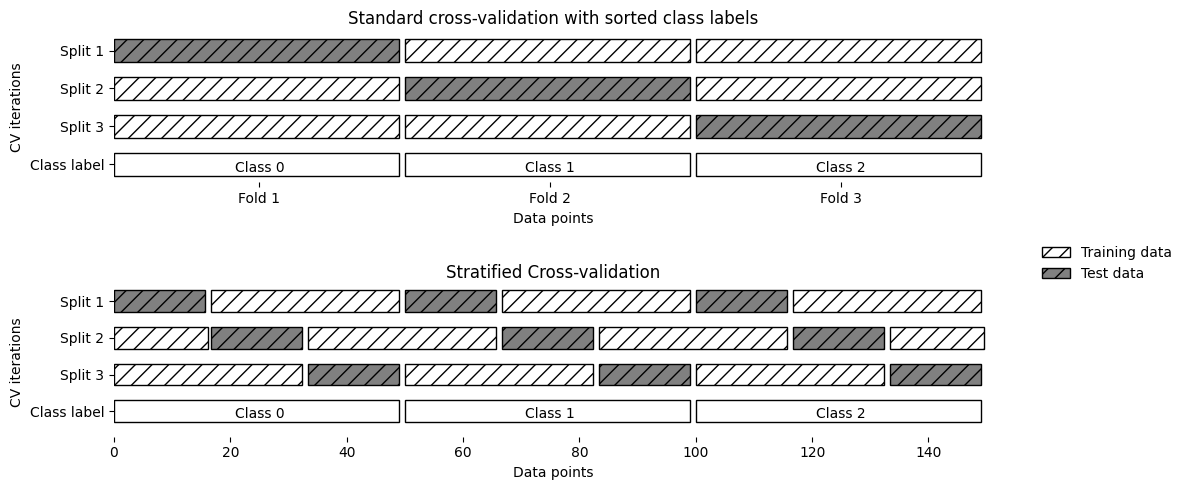

In [8]:
mglearn.plots.plot_stratified_cross_validation()

For example, if 90% of your samples belong to class A and 10% of your samples belong to class B, then stratified cross-validation ensures that in each fold, 90% of samples belong to class A and 10% of samples belong to class B. Formally, if the class proportions in the full dataset are $\pi_c = \frac{n_c}{n}$ for class $c$, then stratified splitting ensures that each fold $i$ has approximately the same proportions: $\pi_c^{(i)} \approx \pi_c$.

It is usually a good idea to use stratified $k$-fold cross-validation instead of $k$-fold cross-validation to evaluate a classifier, because it results in more reliable estimates of generalization performance. For regression, scikit-learn uses the standard $k$-fold cross-validation by default.

### More Control over Cross-Validation

We can adjust the number of folds using the `cv` parameter. However, scikit-learn allows for much finer control over what happens during the splitting of the data by providing a **cross-validation splitter** as the `cv` parameter. For example, to use the standard $k$-fold cross-validation on a classification dataset (without stratification), we first import the `KFold` splitter class:

In [9]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5)
print("Cross-validation scores:\n{}".format(
    cross_val_score(logreg, iris.data, iris.target, cv=kfold)))

Cross-validation scores:
[1.         1.         0.86666667 0.93333333 0.83333333]


Notice that the scores are more variable than with stratified $k$-fold, because without stratification some folds may have unbalanced class distributions. Now let's see what happens with 3-fold `KFold` on the iris dataset where the labels are sorted:

In [10]:
kfold = KFold(n_splits=3)
print("Cross-validation scores:\n{}".format(
    cross_val_score(logreg, iris.data, iris.target, cv=kfold)))

Cross-validation scores:
[0. 0. 0.]


As expected, all three folds produce 0% accuracy, because each fold contains only one class. Remember: each fold corresponds to one of the classes in the iris dataset, so nothing can be learned -- the model trains on two classes and is tested on a third class it has never seen.

Another way to resolve this problem is to **shuffle** the data instead of stratifying the folds, to remove the ordering of the samples by label. We can do that by setting the `shuffle` parameter of `KFold` to `True`. If we shuffle the data, we also need to fix the `random_state` to get a reproducible shuffling:

In [11]:
kfold = KFold(n_splits=3, shuffle=True, random_state=0)
print("Cross-validation scores:\n{}".format(
    cross_val_score(logreg, iris.data, iris.target, cv=kfold)))

Cross-validation scores:
[0.98 0.96 0.96]


Shuffling the data before splitting it yields a much better result -- all folds now achieve above 96% accuracy, because each fold contains a balanced mix of all three classes.

### Leave-One-Out Cross-Validation

Another frequently used cross-validation method is **leave-one-out (LOO)**. You can think of leave-one-out cross-validation as $k$-fold cross-validation where $k = n$ (the number of samples), meaning each fold is a single sample. For each split, you pick a single data point to be the test set. This means we train $n$ models, each leaving out one sample:

$$\text{LOO Score} = \frac{1}{n} \sum_{i=1}^{n} \mathbf{1}[\hat{y}_{-i} = y_i]$$

where $\hat{y}_{-i}$ is the prediction for sample $i$ when it is left out of training. This can be very time consuming, particularly for large datasets, but sometimes provides better estimates on small datasets:

In [12]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
scores = cross_val_score(logreg, iris.data, iris.target, cv=loo)
print("Number of cv iterations: ", len(scores))
print("Mean accuracy: {:.2f}".format(scores.mean()))

Number of cv iterations:  150
Mean accuracy: 0.97


Since the iris dataset has 150 samples, we get 150 iterations -- one model per sample. The mean accuracy of 0.97 is consistent with the five-fold cross-validation estimate. LOO uses the maximum possible training set size ($n - 1$ samples per iteration), which is its main advantage. However, it is computationally expensive: for this small dataset we trained 150 models instead of 5.

### Shuffle-Split Cross-Validation

Another very flexible strategy for cross-validation is **shuffle-split cross-validation**. In shuffle-split cross-validation, each split samples `train_size` many points for the training set and `test_size` many (disjoint) points for the test set. This splitting is repeated `n_splits` times. The following figure illustrates the process:

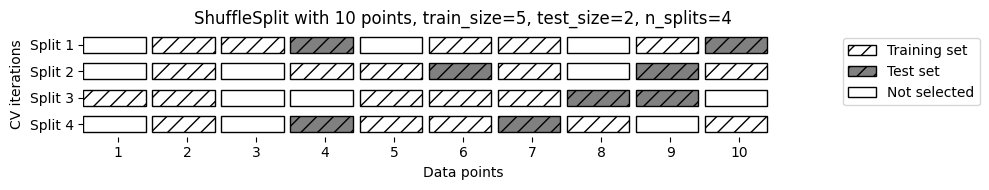

In [13]:
mglearn.plots.plot_shuffle_split()

The following code splits the dataset into 50% training set and 50% test set for 10 iterations. Unlike $k$-fold where each sample appears in exactly one test fold, `ShuffleSplit` can include the same sample in multiple test sets (or none at all):

In [14]:
from sklearn.model_selection import ShuffleSplit
shuffle_split = ShuffleSplit(test_size=.5, train_size=.5, n_splits=10)
scores = cross_val_score(logreg, iris.data, iris.target, cv=shuffle_split)
print("Cross-validation scores:\n{}".format(scores))

Cross-validation scores:
[0.94666667 0.97333333 0.94666667 0.96       0.92       0.96
 0.93333333 0.98666667 0.96       0.96      ]


Shuffle-split cross-validation allows for control over the number of iterations independently of the training and test sizes, which can sometimes be helpful. It also allows for using only part of the data in each iteration, by providing `train_size` and `test_size` settings that don't add up to one. Subsampling the data in this way can be useful for experimenting with large datasets. There is also a stratified variant of `ShuffleSplit`, aptly named `StratifiedShuffleSplit`, which can provide more reliable results for classification tasks.

### Cross-Validation with Groups

Another very common setting for cross-validation is when there are **groups** in the data that are highly related. Say you want to build a system to recognize emotions from pictures of faces, and you collect a dataset of pictures of 100 people where each person is captured multiple times, showing various emotions. The goal is to build a classifier that can correctly identify emotions of people *not* in the dataset. You could use the default stratified cross-validation to measure the performance of a classifier here. However, it is likely that pictures of the same person will be in both the training and the test set. It will be much easier for a classifier to detect emotions in a face that is part of the training set, compared to a completely new face. To accurately evaluate the generalization to new faces, we must therefore ensure that the training and test sets contain images of different people.

To achieve this, we can use `GroupKFold`, which takes an array of groups as argument. The groups array indicates groups in the data that should not be split when creating the training and test sets, and should not be confused with the class label. This example of groups in the data is common in medical applications, where you might have multiple samples from the same patient, but are interested in generalizing to new patients.

The following is an example using a synthetic dataset with a grouping given by the `groups` array:

In [15]:
from sklearn.model_selection import GroupKFold
# create synthetic dataset
X, y = make_blobs(n_samples=12, random_state=0)
# assume the first three samples belong to the same group,
# then the next four, etc.
groups = [0, 0, 0, 1, 1, 1, 1, 2, 2, 3, 3, 3]
scores = cross_val_score(logreg, X, y, groups=groups, cv=GroupKFold(n_splits=3))
print("Cross-validation scores:\n{}".format(scores))

Cross-validation scores:
[0.75       0.6        0.66666667]


The samples don't need to be ordered by group; we just did this for illustration purposes. As you can see, for each split, each group is either entirely in the training set or entirely in the test set. The splits are visualized in the following figure:

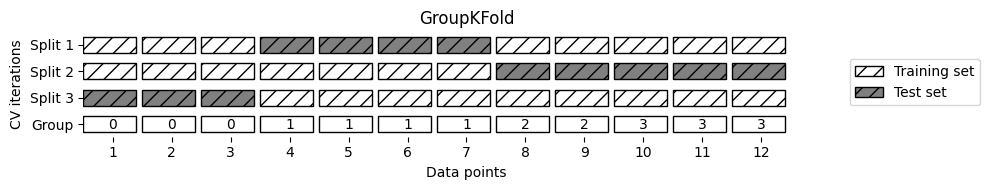

In [16]:
mglearn.plots.plot_group_kfold()

This visualization confirms the key property of `GroupKFold`: no group is ever split across training and test sets. This is essential when data points within a group are correlated -- for example, multiple images of the same patient's tissue, multiple recordings from the same speaker, or multiple time points from the same subject.

There are more splitting strategies for cross-validation in scikit-learn (you can find these in the scikit-learn user guide). However, the standard `KFold`, `StratifiedKFold`, and `GroupKFold` are by far the most commonly used ones.

## Grid Search

Now that we know how to evaluate how well a model generalizes, we can take the next step and improve the model's generalization performance by **tuning its parameters**. We discussed the parameter settings of many of the algorithms in scikit-learn in Chapters 2 and 3, and it is important to understand what the parameters mean before trying to adjust them. Finding the values of the important parameters of a model (the ones that provide the best generalization performance) is a tricky task, but necessary for almost all models and datasets. Because it is such a common task, there are standard methods in scikit-learn to help you with it. The most commonly used method is **grid search**, which basically means trying all possible combinations of the parameters of interest.

Consider the case of a kernel SVM with an RBF (radial basis function) kernel, as implemented in the `SVC` class. As we discussed in Chapter 2, there are two important parameters: the kernel bandwidth $\gamma$ and the regularization parameter $C$. The RBF kernel computes similarity as:

$$K(\mathbf{x}, \mathbf{x}') = \exp\left(-\gamma \|\mathbf{x} - \mathbf{x}'\|^2\right)$$

and $C$ controls the trade-off between maximizing the margin and minimizing the training error. Say we want to try the values 0.001, 0.01, 0.1, 1, 10, and 100 for both $C$ and $\gamma$. Because we have six different settings for $C$ and six for $\gamma$, we have $6 \times 6 = 36$ combinations of parameters in total. Looking at all possible combinations creates a table (or grid) of parameter settings for the SVM.

### Simple Grid Search

We can implement a simple grid search just as for loops over the two parameters, training and evaluating a classifier for each combination:

In [17]:
# naive grid search implementation
from sklearn.svm import SVC
X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, random_state=0)
print("Size of training set: {}   size of test set: {}".format(
    X_train.shape[0], X_test.shape[0]))

best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # for each combination of parameters, train an SVC
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        # evaluate the SVC on the test set
        score = svm.score(X_test, y_test)
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}

print("Best score: {:.2f}".format(best_score))
print("Best parameters: {}".format(best_parameters))

Size of training set: 112   size of test set: 38
Best score: 0.97
Best parameters: {'C': 100, 'gamma': 0.001}


The grid search found that `C=100` and `gamma=0.001` achieves 97% accuracy on the test set. However, this score may be **overly optimistic**, for an important reason.

### The Danger of Overfitting the Parameters and the Validation Set

Given this result, we might be tempted to report that we found a model that performs with 97% accuracy on our dataset. However, this claim could be overly optimistic (or just wrong), for the following reason: we tried many different parameters and selected the one with best accuracy on the test set, but this accuracy won't necessarily carry over to new data. Because we used the test data to adjust the parameters, we can no longer use it to assess how good the model is. This is the same reason we needed to split the data into training and test sets in the first place; we need an independent dataset to evaluate, one that was not used to create the model.

One way to resolve this problem is to split the data again, so we have three sets: the **training set** to build the model, the **validation set** (or development set) to select the parameters of the model, and the **test set** to evaluate the performance of the selected parameters:

$$\text{Data} \rightarrow \underbrace{\text{Training Set}}_{\text{fit model}} + \underbrace{\text{Validation Set}}_{\text{select parameters}} + \underbrace{\text{Test Set}}_{\text{final evaluation}}$$

The following figure illustrates this:

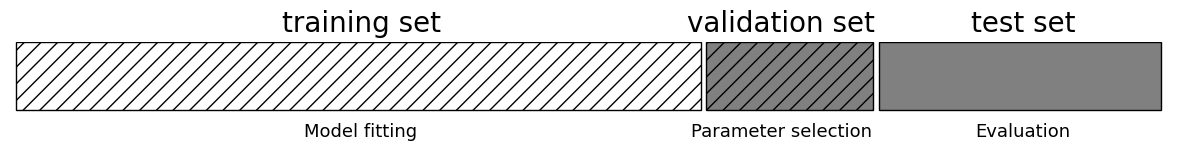

In [18]:
mglearn.plots.plot_threefold_split()

After selecting the best parameters using the validation set, we can rebuild a model using the parameter settings we found, but now training on both the training data and the validation data. This way, we can use as much data as possible to build our model. This leads to the following implementation:

In [19]:
from sklearn.svm import SVC
# split data into train+validation set and test set
X_trainval, X_test, y_trainval, y_test = train_test_split(
    iris.data, iris.target, random_state=0)
# split train+validation set into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(
    X_trainval, y_trainval, random_state=1)
print("Size of training set: {}   size of validation set: {}"
      "   size of test set: {}\n".format(
    X_train.shape[0], X_valid.shape[0], X_test.shape[0]))

best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # for each combination of parameters, train an SVC
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        # evaluate the SVC on the validation set
        score = svm.score(X_valid, y_valid)
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}

# rebuild a model on the combined training and validation set,
# and evaluate it on the test set
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)
test_score = svm.score(X_test, y_test)
print("Best score on validation set: {:.2f}".format(best_score))
print("Best parameters: ", best_parameters)
print("Test set score with best parameters: {:.2f}".format(test_score))

Size of training set: 84   size of validation set: 28   size of test set: 38

Best score on validation set: 0.96
Best parameters:  {'C': 10, 'gamma': 0.001}
Test set score with best parameters: 0.92


The best score on the validation set is 96%: slightly lower than before, probably because we used less data to train the model (`X_train` is now only 84 samples instead of 112, since we carved out a validation set of 28 samples). However, the score on the test set -- the score that actually tells us how well we generalize -- is even lower, at 92%. So we can only claim to classify new data 92% correctly, not 97% correctly as we thought before!

The distinction between the training set, validation set, and test set is fundamentally important to applying machine learning methods in practice. Any choices made based on the test set accuracy "leak" information from the test set into the model. Therefore, it is important to keep a separate test set, which is only used for the final evaluation. It is good practice to do all exploratory analysis and model selection using the combination of a training and a validation set, and reserve the test set for a final evaluation -- this is even true for exploratory visualization. Strictly speaking, evaluating more than one model on the test set and choosing the better of the two will result in an overly optimistic estimate of how accurate the model is.

### Grid Search with Cross-Validation

While the method of splitting the data into a training, a validation, and a test set that we just saw is workable, and relatively commonly used, it is quite sensitive to how exactly the data is split. For a better estimate of the generalization performance, instead of using a single split into a training and a validation set, we can use **cross-validation** to evaluate the performance of each parameter combination. We can code this as follows:

In [20]:
best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # for each combination of parameters, train an SVC
        svm = SVC(gamma=gamma, C=C)
        # perform cross-validation
        scores = cross_val_score(svm, X_trainval, y_trainval, cv=5)
        # compute mean cross-validation accuracy
        score = np.mean(scores)
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}

# rebuild a model on the combined training and validation set
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)

SVC(C=10, gamma=0.1)

To evaluate the accuracy of the SVM using a particular setting of $C$ and $\gamma$ using five-fold cross-validation, we need to train $36 \times 5 = 180$ models. As you can imagine, the main downside of the use of cross-validation is the time it takes to train all these models.

The following visualization illustrates how the best parameter setting is selected. For each parameter setting, five accuracy values are computed (one for each split), then the mean validation accuracy is computed. The parameters with the highest mean validation accuracy are chosen:

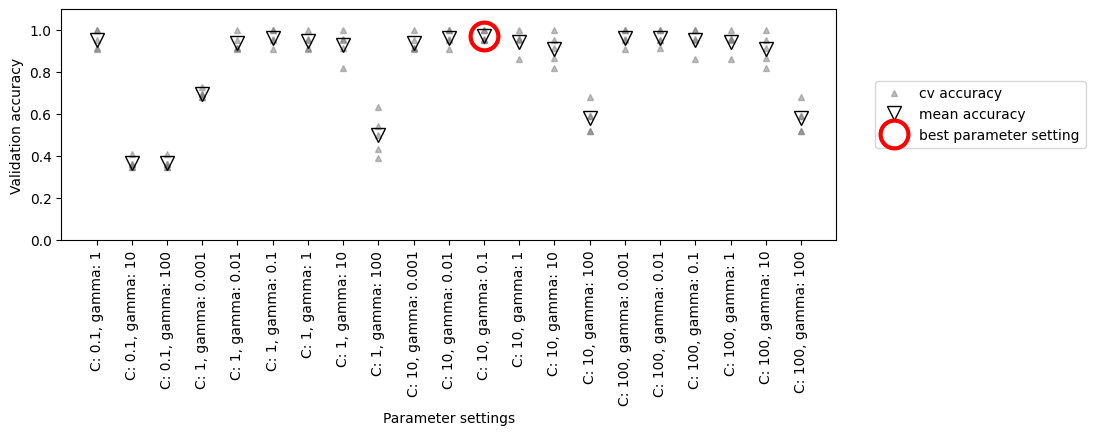

In [21]:
mglearn.plots.plot_cross_val_selection()

The overall process of splitting the data, running the grid search, and evaluating the final parameters is illustrated in the following figure:

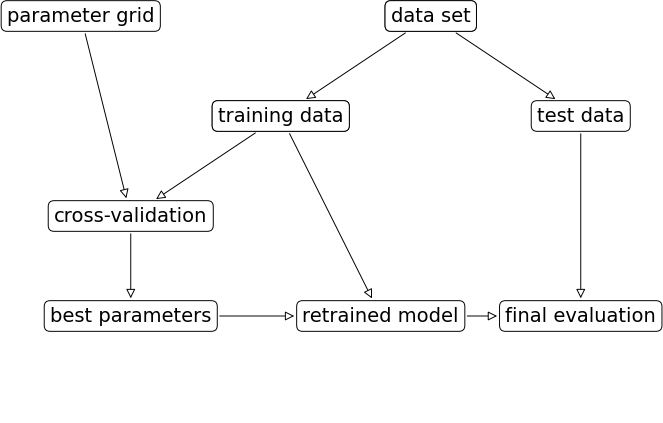

In [22]:
mglearn.plots.plot_grid_search_overview()

### The `GridSearchCV` Class

Because grid search with cross-validation is such a commonly used method to adjust parameters, scikit-learn provides the `GridSearchCV` class, which implements it in the form of an estimator. To use it, you first specify the parameters you want to search over using a dictionary. The keys are parameter names and the values are lists of settings to try. Trying the values 0.001, 0.01, 0.1, 1, 10, and 100 for $C$ and $\gamma$ translates to the following dictionary:

In [23]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
print("Parameter grid:\n{}".format(param_grid))

Parameter grid:
{'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}


We can now instantiate the `GridSearchCV` class with the model (SVC), the parameter grid to search (`param_grid`), and the cross-validation strategy we want to use (say, five-fold stratified cross-validation). We still need to split the data into a training and a test set, to avoid overfitting the parameters:

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
grid_search = GridSearchCV(SVC(), param_grid, cv=5)

X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, random_state=0)

The `grid_search` object behaves just like a classifier; we can call the standard methods `fit`, `predict`, and `score` on it. However, when we call `fit`, it will run cross-validation for each combination of parameters we specified in `param_grid`. Fitting the `GridSearchCV` object not only searches for the best parameters, but also automatically fits a new model on the whole training dataset with the parameters that yielded the best cross-validation performance:

In [25]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1, 10, 100]})

To evaluate how well the best found parameters generalize, we can call `score` on the test set:

In [26]:
print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))

Test set score: 0.97


Choosing the parameters using cross-validation, we actually found a model that achieves 97% accuracy on the test set. The important thing here is that **we did not use the test set to choose the parameters**. The parameters that were found are stored in the `best_params_` attribute, and the best cross-validation accuracy (the mean accuracy over the different splits for this parameter setting) is stored in `best_score_`:

In [27]:
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters: {'C': 10, 'gamma': 0.1}
Best cross-validation score: 0.97


The `GridSearchCV` found that $C = 10$ and $\gamma = 0.1$ produced the best mean cross-validation score of 0.97. When this model is evaluated on the held-out test set, it also achieves 0.97 -- which is reassuring because it means the cross-validation estimate was accurate.

> **Caution:** Be careful not to confuse `best_score_` with the generalization performance of the model as computed by the `score` method on the test set. The `best_score_` attribute stores the mean cross-validation accuracy, with cross-validation performed on the training set. Using the `score` method on the test set evaluates a model trained on the *whole* training set.

Sometimes it is helpful to have access to the actual model that was found. You can access the model with the best parameters trained on the whole training set using the `best_estimator_` attribute:

In [28]:
print("Best estimator:\n{}".format(grid_search.best_estimator_))

Best estimator:
SVC(C=10, gamma=0.1)


### Analyzing the Result of Cross-Validation

It is often helpful to visualize the results of cross-validation, to understand how the model generalization depends on the parameters we are searching. The results of a grid search can be found in the `cv_results_` attribute, which is a dictionary storing all aspects of the search. It is best looked at after converting it to a pandas DataFrame:

In [29]:
import pandas as pd
# convert to DataFrame
results = pd.DataFrame(grid_search.cv_results_)
# show the first 5 rows
display(results.head())

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.005806,0.003113,0.003300,0.001506,0.001,0.001,"{'C': 0.001, 'gamma': 0.001}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22
1,0.007251,0.002513,0.002909,0.001037,0.001,0.010,"{'C': 0.001, 'gamma': 0.01}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22
2,0.003166,0.001700,0.002036,0.001167,0.001,0.100,"{'C': 0.001, 'gamma': 0.1}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22
3,0.008899,0.002831,0.006025,0.003483,0.001,1.000,"{'C': 0.001, 'gamma': 1}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22
4,0.004514,0.001773,0.001714,0.000142,0.001,10.000,"{'C': 0.001, 'gamma': 10}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22


Each row in `results` corresponds to one particular parameter setting (one cell in the grid). For each setting, the results of all cross-validation splits are recorded, as well as the mean and standard deviation over all splits. As we were searching a two-dimensional grid of parameters ($C$ and $\gamma$), this is best visualized as a **heat map**. First we extract the mean validation scores, then reshape them so that the axes correspond to $C$ and $\gamma$:

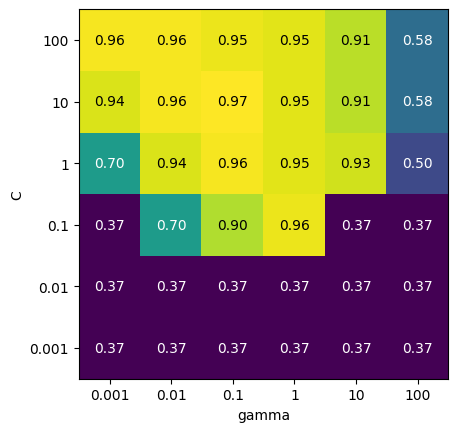

In [30]:
scores = np.array(results.mean_test_score).astype(float).reshape(6, 6)

# plot the mean cross-validation scores
mglearn.tools.heatmap(scores, xlabel='gamma', xticklabels=param_grid['gamma'],
                      ylabel='C', yticklabels=param_grid['C'], cmap="viridis")

Each point in the heat map corresponds to one run of cross-validation, with a particular parameter setting. The color encodes the cross-validation accuracy, with light colors meaning high accuracy and dark colors meaning low accuracy. You can see that `SVC` is very sensitive to the setting of the parameters. For many of the parameter settings, the accuracy is around 40% (barely above the $\frac{1}{3} \approx 33\%$ chance level for three classes), which is quite bad; for other settings the accuracy is around 96%.

We can take away from this plot several important insights. First, the parameters we adjusted are very important for obtaining good performance. Both parameters ($C$ and $\gamma$) matter a lot, as adjusting them can change the accuracy from 40% to 96%. Additionally, the ranges we picked for the parameters are ranges in which we see significant changes in the outcome. It's also important to note that the ranges for the parameters are large enough: the optimum values for each parameter are not on the edges of the plot.

Now let's look at some plots where the result is less ideal, because the search ranges were not chosen properly:

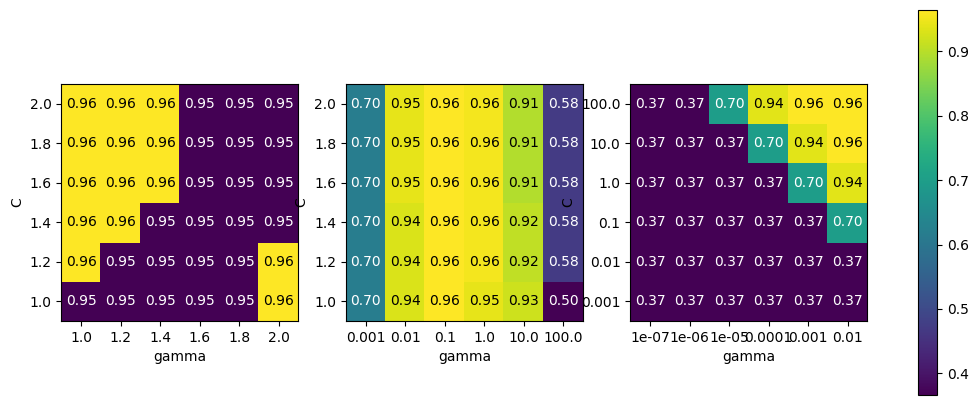

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(13, 5))

param_grid_linear = {'C': np.linspace(1, 2, 6),
                     'gamma': np.linspace(1, 2, 6)}

param_grid_one_log = {'C': np.linspace(1, 2, 6),
                      'gamma': np.logspace(-3, 2, 6)}

param_grid_range = {'C': np.logspace(-3, 2, 6),
                    'gamma': np.logspace(-7, -2, 6)}

for param_grid, ax in zip([param_grid_linear, param_grid_one_log,
                           param_grid_range], axes):
    grid_search = GridSearchCV(SVC(), param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    scores = np.array(grid_search.cv_results_['mean_test_score']).astype(float).reshape(6, 6)

    # plot the mean cross-validation scores
    scores_image = mglearn.tools.heatmap(
        scores, xlabel='gamma', ylabel='C', xticklabels=param_grid['gamma'],
        yticklabels=param_grid['C'], cmap="viridis", ax=ax)

plt.colorbar(scores_image, ax=axes.tolist())

The first panel shows no changes at all, with a constant color over the whole parameter grid. In this case, this is caused by improper scaling and range of the parameters $C$ and $\gamma$ -- the linear spacing between 1 and 2 is far too narrow to see any effect. When parameters span several orders of magnitude (as $C$ and $\gamma$ typically do), a **logarithmic scale** is essential.

The second panel shows a vertical stripe pattern. This indicates that only the setting of the $\gamma$ parameter makes any difference. This could mean that the $\gamma$ parameter is searching over interesting values but the $C$ parameter is not -- or it could mean the $C$ parameter is not important.

The third panel shows changes in both $C$ and $\gamma$. However, we can see that in the entire bottom left of the plot, nothing interesting is happening. The optimum parameter setting is at the top right. As the optimum is on the border of the plot, we can expect that there might be even better values beyond this border, and we might want to change our search range to include more parameters in this region.

Tuning the parameter grid based on the cross-validation scores is perfectly fine, and a good way to explore the importance of different parameters. However, **you should not test different parameter ranges on the final test set** -- as we discussed earlier, evaluation of the test set should happen only once we know exactly what model we want to use.

### Search over Spaces That Are Not Grids

In some cases, trying all possible combinations of all parameters as `GridSearchCV` usually does, is not a good idea. For example, `SVC` has a `kernel` parameter, and depending on which kernel is chosen, other parameters will be relevant. If `kernel='linear'`, the model is linear, and only the $C$ parameter is used. If `kernel='rbf'`, both $C$ and $\gamma$ parameters are used. In this case, searching over all possible combinations of $C$, $\gamma$, and `kernel` wouldn't make sense: if `kernel='linear'`, $\gamma$ is not used, and trying different values for $\gamma$ would be a waste of time.

To deal with these kinds of "conditional" parameters, `GridSearchCV` allows the `param_grid` to be a **list of dictionaries**. Each dictionary in the list is expanded into an independent grid:

In [32]:
param_grid = [{'kernel': ['rbf'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100],
               'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
              {'kernel': ['linear'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100]}]
print("List of grids:\n{}".format(param_grid))

List of grids:
[{'kernel': ['rbf'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}, {'kernel': ['linear'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}]


In the first grid, the `kernel` parameter is always set to `'rbf'`, and both $C$ and $\gamma$ parameters are varied ($6 \times 6 = 36$ combinations). In the second grid, the `kernel` parameter is always set to `'linear'`, and only $C$ is varied (6 combinations). The total number of parameter combinations is $36 + 6 = 42$. Now let's apply this more complex parameter search:

In [33]:
grid_search = GridSearchCV(SVC(), param_grid, cv=5)
grid_search.fit(X_train, y_train)
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best cross-validation score: 0.97


The best model uses the RBF kernel with $C = 10$ and $\gamma = 0.1$. Let's look at the `cv_results_` to confirm that the linear kernel entries correctly have `NaN` for `gamma`:

In [34]:
results = pd.DataFrame(grid_search.cv_results_)
# we display the transposed table so that it better fits on the page:
display(results.T)

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
mean_fit_time,0.001768,0.001562,0.001436,0.001427,0.001421,0.001492,0.001392,0.001461,0.001464,0.001421,...,0.00103,0.001215,0.001604,0.001716,0.001338,0.001416,0.001218,0.001255,0.001132,0.001101
std_fit_time,0.000581,0.000102,0.00001,0.000019,0.00004,0.000019,0.00005,0.000049,0.000054,0.000047,...,0.000048,0.000027,0.000018,0.000021,0.000016,0.000172,0.000048,0.00015,0.000048,0.000044
mean_score_time,0.001089,0.000954,0.000889,0.000869,0.000867,0.000872,0.000873,0.000903,0.0009,0.000966,...,0.000799,0.000816,0.000845,0.000895,0.000806,0.000881,0.000885,0.001025,0.000807,0.000793
std_score_time,0.000207,0.000082,0.000066,0.000024,0.000017,0.000007,0.000047,0.000045,0.000064,0.000124,...,0.000013,0.000012,0.000017,0.000015,0.000008,0.000069,0.000021,0.000263,0.000017,0.000014
param_C,0.001,0.001,0.001,0.001,0.001,0.001,0.01,0.01,0.01,0.01,...,100.0,100.0,100.0,100.0,0.001,0.01,0.1,1.0,10.0,100.0
param_gamma,0.001,0.01,0.1,1.0,10.0,100.0,0.001,0.01,0.1,1.0,...,0.1,1.0,10.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN
param_kernel,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,...,rbf,rbf,rbf,rbf,linear,linear,linear,linear,linear,linear
params,"{'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 1, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 10, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 100, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 1, 'kernel': 'rbf'}",...,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 100, 'gamma': 1, 'kernel': 'rbf'}","{'C': 100, 'gamma': 10, 'kernel': 'rbf'}","{'C': 100, 'gamma': 100, 'kernel': 'rbf'}","{'C': 0.001, 'kernel': 'linear'}","{'C': 0.01, 'kernel': 'linear'}","{'C': 0.1, 'kernel': 'linear'}","{'C': 1, 'kernel': 'linear'}","{'C': 10, 'kernel': 'linear'}","{'C': 100, 'kernel': 'linear'}"
split0_test_score,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,...,1.0,0.956522,0.869565,0.521739,0.347826,0.869565,1.0,1.0,1.0,0.956522
split1_test_score,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,...,0.956522,0.956522,0.913043,0.521739,0.347826,0.869565,0.913043,0.956522,1.0,0.956522


The results table shows all 42 parameter combinations. For the first 36 rows (RBF kernel), both `param_C` and `param_gamma` have values. For the last 6 rows (linear kernel), `param_gamma` is `NaN`, confirming that only $C$ was varied when the kernel is linear. This is more efficient than testing all $6 \times 6 \times 2 = 72$ combinations, because we avoided the 36 meaningless combinations of `gamma` with the linear kernel.

### Nested Cross-Validation

In the preceding examples, we still have a single split of the data into training and test sets, which might make our results unstable. We can go a step further, and instead of splitting the original data into training and test sets once, use multiple splits of cross-validation. This results in what is called **nested cross-validation**.

In nested cross-validation, there is an **outer loop** over splits of the data into training and test sets. For each of them, a grid search is run (which might result in different best parameters for each split in the outer loop). Then, for each outer split, the test set score using the best settings is reported. The result of this procedure is a list of scores -- not a model, and not a parameter setting.

Implementing nested cross-validation in scikit-learn is straightforward. We call `cross_val_score` with an instance of `GridSearchCV` as the model:

In [35]:
param_grid = [{'kernel': ['rbf'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100],
               'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
              {'kernel': ['linear'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100]}]

scores = cross_val_score(GridSearchCV(SVC(), param_grid, cv=5),
                         iris.data, iris.target, cv=5)
print("Cross-validation scores: ", scores)
print("Mean cross-validation score: {:.2f}".format(scores.mean()))

Cross-validation scores:  [0.96666667 1.         0.9        0.96666667 1.        ]
Mean cross-validation score: 0.97


The result of our nested cross-validation can be summarized as "SVC can achieve 97% mean cross-validation accuracy on the iris dataset" -- nothing more and nothing less.

Here, we used stratified five-fold cross-validation in both the inner and the outer loop. As our `param_grid` contains $36 + 6 = 42$ combinations of parameters, this results in a whopping $42 \times 5 \times 5 = 1{,}050$ models being built, making nested cross-validation a very expensive procedure. The computational cost scales as:

$$\text{Total models} = |\text{param\_grid}| \times k_{\text{inner}} \times k_{\text{outer}}$$

It can be helpful to visualize nested cross-validation as explicit for loops. Here is a simplified implementation:

In [36]:
def nested_cv(X, y, inner_cv, outer_cv, Classifier, parameter_grid):
    outer_scores = []
    # for each split of the data in the outer cross-validation
    for training_samples, test_samples in outer_cv.split(X, y):
        # find best parameter using inner cross-validation
        best_parms = {}
        best_score = -np.inf
        # iterate over parameters
        for parameters in parameter_grid:
            # accumulate score over inner splits
            cv_scores = []
            # iterate over inner cross-validation
            for inner_train, inner_test in inner_cv.split(
                    X[training_samples], y[training_samples]):
                # build classifier given parameters and training data
                clf = Classifier(**parameters)
                clf.fit(X[inner_train], y[inner_train])
                # evaluate on inner test set
                score = clf.score(X[inner_test], y[inner_test])
                cv_scores.append(score)
            # compute mean score over inner folds
            mean_score = np.mean(cv_scores)
            if mean_score > best_score:
                best_score = mean_score
                best_params = parameters
        # build classifier on best parameters using outer training set
        clf = Classifier(**best_params)
        clf.fit(X[training_samples], y[training_samples])
        # evaluate
        outer_scores.append(clf.score(X[test_samples], y[test_samples]))
    return np.array(outer_scores)

Now let's run this function on the iris dataset:

In [37]:
from sklearn.model_selection import ParameterGrid, StratifiedKFold
scores = nested_cv(iris.data, iris.target, StratifiedKFold(5),
                   StratifiedKFold(5), SVC, ParameterGrid(param_grid))
print("Cross-validation scores: {}".format(scores))

Cross-validation scores: [0.96666667 1.         0.96666667 0.96666667 1.        ]


The scores match the result from `cross_val_score(GridSearchCV(...))` above, confirming our understanding of the nested procedure.

### Parallelizing Cross-Validation and Grid Search

While running a grid search over many parameters and on large datasets can be computationally challenging, it is also **embarrassingly parallel**. This means that building a model using a particular parameter setting on a particular cross-validation split can be done completely independently from the other parameter settings and models. This makes grid search and cross-validation ideal candidates for parallelization over multiple CPU cores. You can make use of multiple cores in `GridSearchCV` and `cross_val_score` by setting the `n_jobs` parameter to the number of CPU cores you want to use. You can set `n_jobs=-1` to use all available cores.

You should be aware that scikit-learn does not allow nesting of parallel operations. So, if you are using the `n_jobs` option on your model (for example, a random forest), you cannot use it in `GridSearchCV` to search over this model.

## Summary of Cross-Validation and Grid Search

In this section, we covered the essential tools for model evaluation and parameter tuning:

**Cross-validation** provides a more robust estimate of generalization performance than a single train/test split. The $k$-fold variant trains $k$ models, each using $\frac{k-1}{k}$ of the data for training. For classification, **stratified** $k$-fold ensures each fold maintains the same class proportions as the full dataset.

**Grid search** systematically explores combinations of hyperparameters. The key insight is to use a **validation set** (or cross-validation) to select parameters, keeping the test set untouched for final evaluation. The `GridSearchCV` class combines both steps, searching over a parameter grid using cross-validation and automatically retraining the best model on the full training set.

**Nested cross-validation** provides an unbiased estimate of how well grid search will work on a given dataset, at the cost of training $|\text{param\_grid}| \times k_{\text{inner}} \times k_{\text{outer}}$ models.

In the next part of this chapter, we will discuss evaluation metrics beyond accuracy and $R^2$, including precision, recall, ROC curves, and more.

---

# Part 2: Evaluation Metrics and Scoring

So far, we have evaluated classification performance using accuracy (the fraction of correctly classified samples) and regression performance using $R^2$. However, these are only two of the many possible ways to summarize how well a supervised model performs on a given dataset. In practice, these evaluation metrics might not be appropriate for your application, and it is important to choose the right metric when selecting between models and adjusting parameters.

### Keep the End Goal in Mind

When selecting a metric, you should always have the end goal of the machine learning application in mind. In practice, we are usually interested not just in making accurate predictions, but in using these predictions as part of a larger decision-making process. Before picking a machine learning metric, you should think about the high-level goal of the application, often called the **business metric**. The consequences of choosing a particular algorithm for a machine learning application are called the **business impact**.

Maybe the high-level goal is avoiding traffic accidents, or decreasing the number of hospital admissions. It could also be getting more users for your website, or having users spend more money in your shop. When choosing a model or adjusting parameters, you should pick the model or parameter values that have the most positive influence on the business metric.

In the early stages of development, it is often infeasible to put models into production just for testing purposes, because of the high business or personal risks that can be involved. Therefore we often need to find some surrogate evaluation procedure, using an evaluation metric that is easier to compute. Keep in mind that this is only a surrogate, and it pays off to find the closest metric to the original business goal that is feasible to evaluate.

In this section, we will first discuss metrics for the important special case of binary classification, then turn to multiclass classification and finally regression.

## Metrics for Binary Classification

Binary classification is arguably the most common and conceptually simple application of machine learning in practice. However, there are still a number of caveats in evaluating even this simple task. Before we dive into alternative metrics, let's have a look at the ways in which measuring accuracy might be misleading. Remember that for binary classification, we often speak of a **positive class** and a **negative class**, with the understanding that the positive class is the one we are looking for.

### Kinds of Errors

Often, accuracy is not a good measure of predictive performance, as the number of mistakes we make does not contain all the information we are interested in. Imagine an application to screen for the early detection of cancer using an automated test. If the test is negative, the patient will be assumed healthy, while if the test is positive, the patient will undergo additional screening.

One possible mistake is that a healthy patient will be classified as positive, leading to additional testing. An incorrect positive prediction is called a **false positive** (FP). The other possible mistake is that a sick patient will be classified as negative, and will not receive further tests and treatment. An incorrect negative prediction is called a **false negative** (FN). In statistics, a false positive is also known as a **Type I error**, and a false negative as a **Type II error**. In the cancer diagnosis example, it is clear that we want to avoid false negatives as much as possible, while false positives can be viewed as more of a minor nuisance.

### Imbalanced Datasets

Types of errors play an important role when one of two classes is much more frequent than the other one. This is very common in practice; a good example is click-through prediction, where 99% of the samples belong to the "no click" class. Datasets in which one class is much more frequent than the other are often called **imbalanced datasets**.

Now let's say you build a classifier that is 99% accurate on the click prediction task. What does that tell you? You can achieve 99% accuracy without building a machine learning model, by always predicting "no click."

To illustrate, we'll create a 9:1 imbalanced dataset from the digits dataset, by classifying the digit 9 against the nine other classes:

In [38]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

digits = load_digits()
y = digits.target == 9

X_train, X_test, y_train, y_test = train_test_split(
    digits.data, y, random_state=0)

We can use the `DummyClassifier` to always predict the majority class (here "not nine") to see how uninformative accuracy can be:

In [39]:
from sklearn.dummy import DummyClassifier
dummy_majority = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
pred_most_frequent = dummy_majority.predict(X_test)
print("Unique predicted labels: {}".format(np.unique(pred_most_frequent)))
print("Test score: {:.2f}".format(dummy_majority.score(X_test, y_test)))

Unique predicted labels: [False]
Test score: 0.90


We obtained close to 90% accuracy without learning anything. This might seem striking, but think about it: with roughly 90% of data points being "not nine," always guessing the majority class automatically gets $\frac{n_{\text{majority}}}{n_{\text{total}}} \approx 0.90$ accuracy. Imagine someone telling you their model is 90% accurate -- depending on the problem, that might be possible by just predicting one class!

Let's compare this against using an actual classifier:

In [40]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth=2).fit(X_train, y_train)
pred_tree = tree.predict(X_test)
print("Test score: {:.2f}".format(tree.score(X_test, y_test)))

Test score: 0.92


According to accuracy, the `DecisionTreeClassifier` is only slightly better than the constant predictor (0.92 vs. 0.90). This could indicate either that something is wrong with how we used `DecisionTreeClassifier`, or that accuracy is in fact not a good measure here. For comparison purposes, let's evaluate two more classifiers:

In [41]:
from sklearn.linear_model import LogisticRegression

dummy = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
pred_dummy = dummy.predict(X_test)
print("dummy score: {:.2f}".format(dummy.score(X_test, y_test)))

logreg = LogisticRegression(C=0.1, max_iter=1000).fit(X_train, y_train)
pred_logreg = logreg.predict(X_test)
print("logreg score: {:.2f}".format(logreg.score(X_test, y_test)))

dummy score: 0.90
logreg score: 0.98


`LogisticRegression` produces very good results at 0.98, while the dummy classifier achieves 0.90 by always predicting the majority class. However, even 0.90 accuracy sounds impressive if you don't know the class distribution. The problem here is that accuracy alone is an inadequate measure for quantifying predictive performance in this imbalanced setting. We would like metrics that tell us how much better a model is than making "most frequent" predictions.

### Confusion Matrices

One of the most comprehensive ways to represent the result of evaluating binary classification is using **confusion matrices**. Let's inspect the predictions of `LogisticRegression` using the `confusion_matrix` function:

In [42]:
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(y_test, pred_logreg)
print("Confusion matrix:\n{}".format(confusion))

Confusion matrix:
[[402   1]
 [  6  41]]


The output of `confusion_matrix` is a two-by-two array, where the rows correspond to the true classes and the columns correspond to the predicted classes. Each entry counts how often a sample belonging to the row class was classified as the column class. The following illustration shows the meaning:

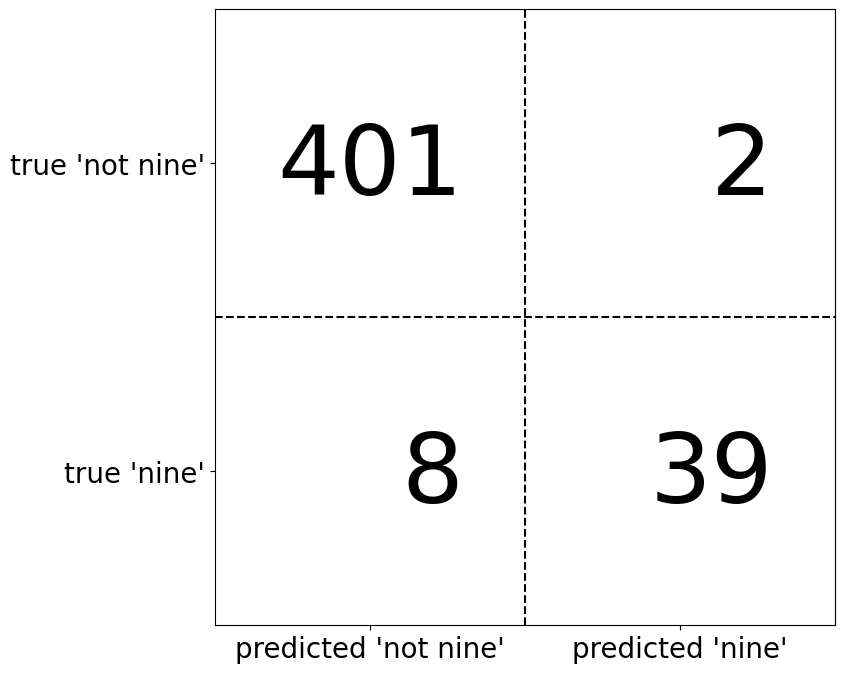

In [43]:
mglearn.plots.plot_confusion_matrix_illustration()

Entries on the main diagonal of the confusion matrix correspond to correct classifications, while other entries tell us how many samples of one class got mistakenly classified as another class.

If we declare "a nine" the positive class, we can relate the entries of the confusion matrix with the terms false positive and false negative. We call correctly classified positive samples **true positives (TP)** and correctly classified negative samples **true negatives (TN)**. These terms are abbreviated FP, FN, TP, and TN:

| | Predicted Negative | Predicted Positive |
|---|---|---|
| **Actually Negative** | TN | FP |
| **Actually Positive** | FN | TP |

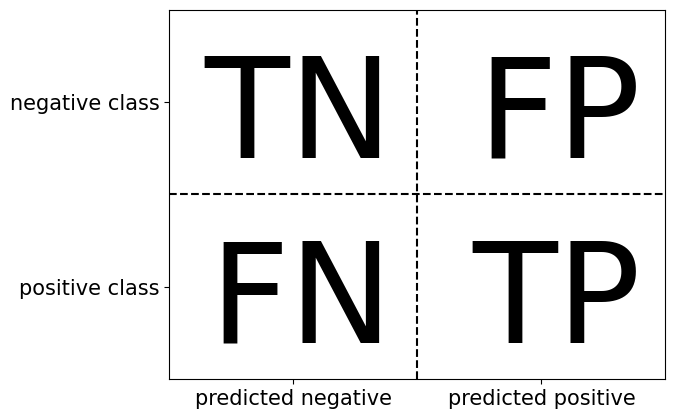

In [44]:
mglearn.plots.plot_binary_confusion_matrix()

Now let's use the confusion matrix to compare all the models we fitted:

In [45]:
print("Most frequent class:")
print(confusion_matrix(y_test, pred_most_frequent))
print("\nDummy model:")
print(confusion_matrix(y_test, pred_dummy))
print("\nDecision tree:")
print(confusion_matrix(y_test, pred_tree))
print("\nLogistic Regression")
print(confusion_matrix(y_test, pred_logreg))

Most frequent class:
[[403   0]
 [ 47   0]]

Dummy model:
[[403   0]
 [ 47   0]]

Decision tree:
[[390  13]
 [ 24  23]]

Logistic Regression
[[402   1]
 [  6  41]]


Looking at the confusion matrix, it is quite clear that something is wrong with `pred_most_frequent`, because it always predicts the same class -- there are zero true positives and zero false positives. The `pred_dummy` behaves the same way. The predictions made by the decision tree make more sense: it correctly identifies 23 nines (TP = 23), but misclassifies 13 non-nines as nines (FP = 13) and misses 24 actual nines (FN = 24). The logistic regression does best: TP = 41, FP = 1, FN = 6, TN = 402.

From this comparison, it is clear that only the decision tree and the logistic regression give reasonable results, and that the logistic regression works better on all accounts. However, inspecting the full confusion matrix is a bit cumbersome. There are several ways to summarize the information, which we will discuss next.

### Precision, Recall, and F-Score

**Accuracy** can be expressed in terms of the confusion matrix entries:

$$\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$$

In other words, accuracy is the number of correct predictions (TP and TN) divided by the total number of samples.

**Precision** measures how many of the samples predicted as positive are actually positive:

$$\text{Precision} = \frac{TP}{TP + FP}$$

Precision is used as a performance metric when the goal is to limit the number of false positives. As an example, imagine a model for predicting whether a new drug will be effective in clinical trials -- it is important that the model does not produce many false positives, so it should have high precision. Precision is also known as **positive predictive value (PPV)**.

**Recall**, on the other hand, measures how many of the positive samples are captured by the positive predictions:

$$\text{Recall} = \frac{TP}{TP + FN}$$

Recall is used as performance metric when we need to identify all positive samples; that is, when it is important to avoid false negatives. The cancer diagnosis example is a good case for this. Other names for recall are **sensitivity**, **hit rate**, or **true positive rate (TPR)**.

There is a fundamental trade-off between optimizing recall and optimizing precision. You can trivially obtain a perfect recall if you predict all samples to belong to the positive class -- there will be no false negatives. However, this will result in many false positives, so precision will be very low. Conversely, predicting only the single most confident sample as positive will yield perfect precision but terrible recall.

One way to summarize precision and recall is the **$F_1$-score**, which is the harmonic mean of precision and recall:

$$F_1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}} = \frac{2 \cdot TP}{2 \cdot TP + FP + FN}$$

The harmonic mean is always less than or equal to the arithmetic mean, and it is particularly low when either precision or recall is small -- thus the $F_1$-score requires *both* precision and recall to be high for the overall score to be high. Let's compute it on the "nine vs. rest" predictions:

In [46]:
from sklearn.metrics import f1_score
print("f1 score most frequent: {:.2f}".format(
    f1_score(y_test, pred_most_frequent, zero_division=0)))
print("f1 score dummy: {:.2f}".format(f1_score(y_test, pred_dummy, zero_division=0)))
print("f1 score tree: {:.2f}".format(f1_score(y_test, pred_tree)))
print("f1 score logistic regression: {:.2f}".format(
    f1_score(y_test, pred_logreg)))

f1 score most frequent: 0.00
f1 score dummy: 0.00
f1 score tree: 0.55
f1 score logistic regression: 0.92


Notice two things. First, the $F_1$-score for the `most_frequent` and dummy predictions is 0.00 -- since there are no true positives, both precision and recall are zero, making the denominator of the $F_1$ formula zero. Second, we see a clear distinction between the dummy predictions ($F_1 = 0.00$), the tree ($F_1 = 0.55$), and logistic regression ($F_1 = 0.92$). The $F_1$-score captures our intuition of what makes a good model much better than accuracy did, which showed 0.90 for both the useless dummy and the tree.

If we want a more comprehensive summary, we can use the `classification_report` convenience function to compute precision, recall, and $F_1$ for each class:

In [47]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_most_frequent,
                            target_names=["not nine", "nine"], zero_division=0))

              precision    recall  f1-score   support

    not nine       0.90      1.00      0.94       403
        nine       0.00      0.00      0.00        47

    accuracy                           0.90       450
   macro avg       0.45      0.50      0.47       450
weighted avg       0.80      0.90      0.85       450



The `classification_report` produces one line per class and reports precision, recall, and $F_1$ with that class as the positive class. For the "not nine" class with the most-frequent model, we have a recall of 1.00 (we classified everything as "not nine," so no negatives were missed from that class's perspective). But for the "nine" class, everything is 0.00 -- we never predicted any nines. The **support** column shows the number of samples in each class (403 vs. 47, confirming the 9:1 imbalance).

Here are the reports for the dummy classifier and the logistic regression:

In [48]:
print(classification_report(y_test, pred_dummy,
                            target_names=["not nine", "nine"], zero_division=0))

              precision    recall  f1-score   support

    not nine       0.90      1.00      0.94       403
        nine       0.00      0.00      0.00        47

    accuracy                           0.90       450
   macro avg       0.45      0.50      0.47       450
weighted avg       0.80      0.90      0.85       450



In [49]:
print(classification_report(y_test, pred_logreg,
                            target_names=["not nine", "nine"]))

              precision    recall  f1-score   support

    not nine       0.99      1.00      0.99       403
        nine       0.98      0.87      0.92        47

    accuracy                           0.98       450
   macro avg       0.98      0.93      0.96       450
weighted avg       0.98      0.98      0.98       450



The logistic regression achieves precision = 0.98 and recall = 0.87 for the "nine" class, and near-perfect scores for the "not nine" class. The weighted average $F_1$ is 0.98. Comparing the full reports makes the superiority of the logistic regression model crystal clear, even though accuracy alone (0.98 vs. 0.90) might not have conveyed how different the models truly are.

### Taking Uncertainty into Account

The confusion matrix and the classification report provide a very detailed analysis of a particular set of predictions. However, the predictions themselves already threw away a lot of information that is contained in the model. Most classifiers provide a `decision_function` or a `predict_proba` method to assess degrees of certainty about predictions. Making predictions can be seen as **thresholding** the output of `decision_function` or `predict_proba` at a certain fixed point -- in binary classification, we use $t = 0$ for the decision function and $t = 0.5$ for `predict_proba`:

$$\hat{y} = \begin{cases} 1 & \text{if } f(\mathbf{x}) > t \\ 0 & \text{otherwise} \end{cases}$$

where $f(\mathbf{x})$ is the decision function value.

The following is an example of an imbalanced binary classification task, with 400 points in the negative class classified against 50 points in the positive class:

In [50]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=[400, 50], centers=np.array([[0, 0], [5, 5]]),
                  cluster_std=[7.0, 2], random_state=22)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
svc = SVC(gamma=.05).fit(X_train, y_train)

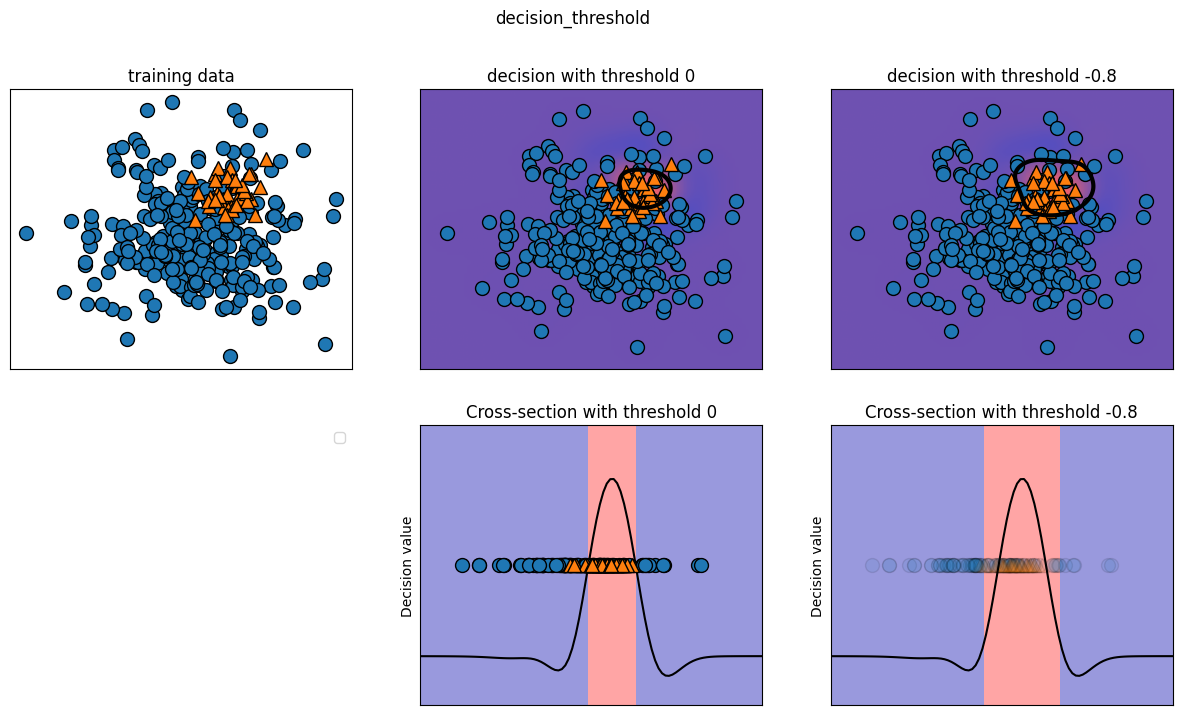

In [51]:
mglearn.plots.plot_decision_threshold()

The plots show the values of the decision function as a heat map. The black circle denotes the threshold of the decision function being exactly zero. Points inside this circle will be classified as the positive class (class 1), and points outside as the negative class (class 0). We can evaluate precision and recall for both classes:

In [52]:
print(classification_report(y_test, svc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92        96
           1       0.00      0.00      0.00        17

    accuracy                           0.85       113
   macro avg       0.42      0.50      0.46       113
weighted avg       0.72      0.85      0.78       113



For class 1, we get zero recall and zero precision -- the classifier fails to identify any positive samples at the default threshold. Because class 0 is so much larger, the classifier focuses entirely on getting class 0 right.

Let's assume it is more important to have a high recall for class 1 (as in cancer screening). We can adjust the predictions by **changing the decision threshold** away from 0:

In [53]:
y_pred_lower_threshold = svc.decision_function(X_test) > -.8

In [54]:
print(classification_report(y_test, y_pred_lower_threshold))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94        96
           1       0.78      0.41      0.54        17

    accuracy                           0.89       113
   macro avg       0.84      0.70      0.74       113
weighted avg       0.88      0.89      0.88       113



By lowering the threshold from 0 to $-0.8$, the recall of the positive class increased (from 0.00 to 0.41), though precision also shifted. We are now classifying a larger region of space as positive. If you value precision over recall or vice versa, or your data is heavily imbalanced, **changing the decision threshold is the easiest way to obtain better results**.

> **Caution:** If you do set a threshold, be careful not to do so using the test set. As with any other parameter, setting a decision threshold on the test set is likely to yield overly optimistic results. Use a validation set or cross-validation instead.

### Precision-Recall Curves and ROC Curves

Rather than picking a single threshold, it is instructive to look at **all possible thresholds** and the resulting trade-offs of precision and recall. This is done using the **precision-recall curve**. You can find the function in `sklearn.metrics`. It needs the ground truth labeling and predicted uncertainties (from `decision_function` or `predict_proba`):

In [55]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(
    y_test, svc.decision_function(X_test))

The `precision_recall_curve` function returns precision and recall values for all possible thresholds in sorted order, so we can plot a curve. Let's use more data points for a smoother curve:

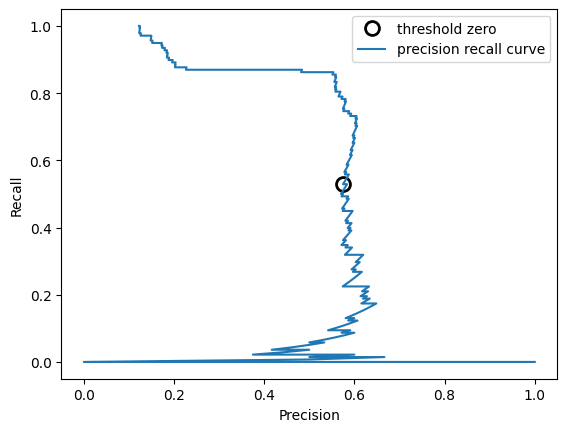

In [56]:
# Use more data points for a smoother curve
X, y = make_blobs(n_samples=[4000, 500], centers=np.array([[0, 0], [5, 5]]),
                  cluster_std=[7.0, 2], random_state=22)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

svc = SVC(gamma=.05).fit(X_train, y_train)
precision, recall, thresholds = precision_recall_curve(
    y_test, svc.decision_function(X_test))

# find threshold closest to zero
close_zero = np.argmin(np.abs(thresholds))
plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10,
         label="threshold zero", fillstyle="none", c='k', mew=2)

plt.plot(precision, recall, label="precision recall curve")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(loc="best")

Each point along the curve corresponds to a possible threshold of the `decision_function`. The black circle marks the point that corresponds to a threshold of 0 (the default). The closer a curve stays to the upper-right corner, the better the classifier -- a point at the upper right means high precision and high recall for the same threshold.

The curve starts at the top-left corner (low threshold, everything classified as positive: high recall, low precision) and moves toward the bottom-right as the threshold increases (fewer positive predictions: lower recall, higher precision).

Different classifiers can work well in different parts of the curve. Let's compare the SVM with a random forest:

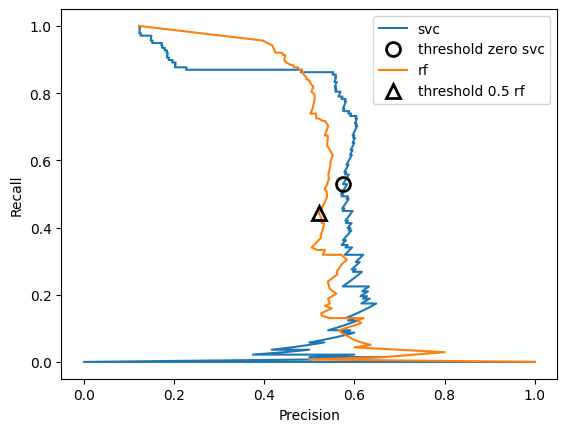

In [57]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=0, max_features=2)
rf.fit(X_train, y_train)

# RandomForestClassifier has predict_proba, but not decision_function
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(
    y_test, rf.predict_proba(X_test)[:, 1])

plt.plot(precision, recall, label="svc")
plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10,
         label="threshold zero svc", fillstyle="none", c='k', mew=2)

plt.plot(precision_rf, recall_rf, label="rf")
close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))
plt.plot(precision_rf[close_default_rf], recall_rf[close_default_rf], '^', c='k',
         markersize=10, label="threshold 0.5 rf", fillstyle="none", mew=2)

plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(loc="best")

From the comparison plot we can see how the two classifiers perform at different operating points. If we only looked at the $F_1$-score to compare overall performance, we would miss these subtleties. The $F_1$-score only captures one point on the precision-recall curve, the one given by the default threshold:

In [58]:
print("f1_score of random forest: {:.3f}".format(
    f1_score(y_test, rf.predict(X_test))))
print("f1_score of svc: {:.3f}".format(f1_score(y_test, svc.predict(X_test))))

f1_score of random forest: 0.472
f1_score of svc: 0.553


One way to summarize the entire precision-recall curve is by computing the **area under the curve**, also known as the **average precision (AP)**:

$$\text{AP} = \sum_{k} (R_k - R_{k-1}) \cdot P_k$$

where $P_k$ and $R_k$ are the precision and recall at the $k$-th threshold. Average precision always returns a value between 0 (worst) and 1 (best). The average precision of a random classifier equals the fraction of positive samples in the dataset:

In [59]:
from sklearn.metrics import average_precision_score
ap_rf = average_precision_score(y_test, rf.predict_proba(X_test)[:, 1])
ap_svc = average_precision_score(y_test, svc.decision_function(X_test))
print("Average precision of random forest: {:.3f}".format(ap_rf))
print("Average precision of svc: {:.3f}".format(ap_svc))

Average precision of random forest: 0.519
Average precision of svc: 0.532


When averaging over all possible thresholds, the SVM and random forest perform similarly. This is different from the result we got from $F_1$ alone.

### Receiver Operating Characteristics (ROC) and AUC

There is another tool commonly used to analyze classifier behavior at different thresholds: the **ROC curve** (Receiver Operating Characteristics). Similar to the precision-recall curve, the ROC curve considers all possible thresholds, but instead of reporting precision and recall, it shows the **false positive rate (FPR)** against the **true positive rate (TPR)**. Recall that the true positive rate is simply another name for recall, while the false positive rate is the fraction of false positives out of all negative samples:

$$\text{TPR} = \frac{TP}{TP + FN} \quad \text{(same as Recall)}$$

$$\text{FPR} = \frac{FP}{FP + TN}$$

The ROC curve can be computed using the `roc_curve` function:

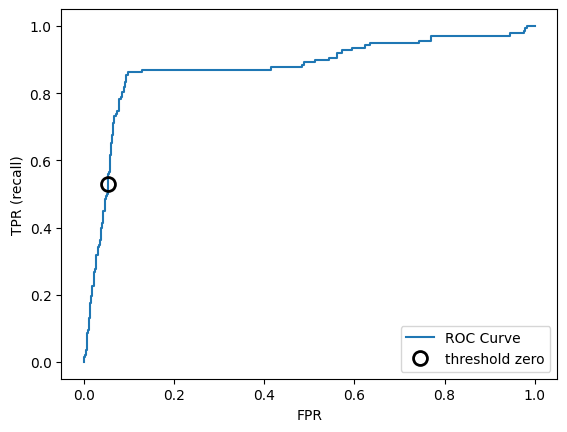

In [60]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, svc.decision_function(X_test))

plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
# find threshold closest to zero
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
         label="threshold zero", fillstyle="none", c='k', mew=2)
plt.legend(loc=4)

For the ROC curve, the ideal curve is close to the top left: you want a classifier that produces a high recall (TPR) while keeping a low false positive rate (FPR). A diagonal line from $(0, 0)$ to $(1, 1)$ represents a random classifier, and any curve above the diagonal is doing better than chance.

You can find a comparison of the random forest and the SVM using ROC curves in the following plot:

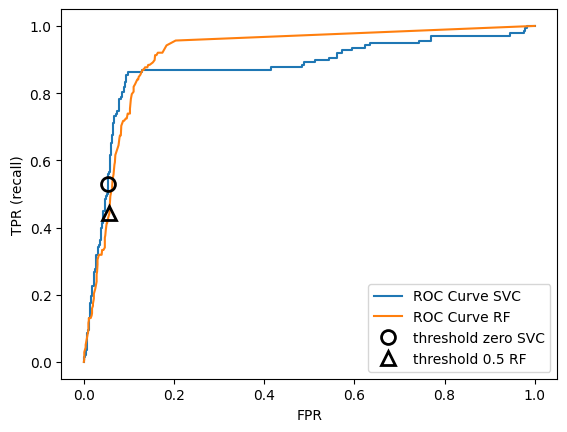

In [61]:
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])

plt.plot(fpr, tpr, label="ROC Curve SVC")
plt.plot(fpr_rf, tpr_rf, label="ROC Curve RF")

plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
         label="threshold zero SVC", fillstyle="none", c='k', mew=2)
close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))
plt.plot(fpr_rf[close_default_rf], tpr_rf[close_default_rf], '^', markersize=10,
         label="threshold 0.5 RF", fillstyle="none", c='k', mew=2)
plt.legend(loc=4)

As for the precision-recall curve, we often want to summarize the ROC curve using a single number: the **area under the ROC curve**, commonly just called the **AUC**. The AUC has an elegant probabilistic interpretation:

$$\text{AUC} = P\left(f(x^+) > f(x^-)\right)$$

where $x^+$ is a randomly drawn positive sample and $x^-$ is a randomly drawn negative sample. In other words, the AUC is the probability that a randomly chosen positive sample has a higher score than a randomly chosen negative sample. A perfect AUC of 1 means all positive points are scored higher than all negative points:

In [62]:
from sklearn.metrics import roc_auc_score
rf_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
svc_auc = roc_auc_score(y_test, svc.decision_function(X_test))
print("AUC for Random Forest: {:.3f}".format(rf_auc))
print("AUC for SVC: {:.3f}".format(svc_auc))

AUC for Random Forest: 0.912
AUC for SVC: 0.874


Predicting randomly always produces an AUC of 0.5, no matter how imbalanced the classes. This makes AUC a much better metric for imbalanced classification problems than accuracy. For classification problems with imbalanced classes, using AUC for model selection is often much more meaningful than using accuracy.

Let's go back to the digits dataset, classifying digit 9 against the rest, with an SVM using three different values of $\gamma$:

gamma = 1.00  accuracy = 0.90  AUC = 0.50
gamma = 0.05  accuracy = 0.90  AUC = 1.00
gamma = 0.01  accuracy = 0.90  AUC = 1.00


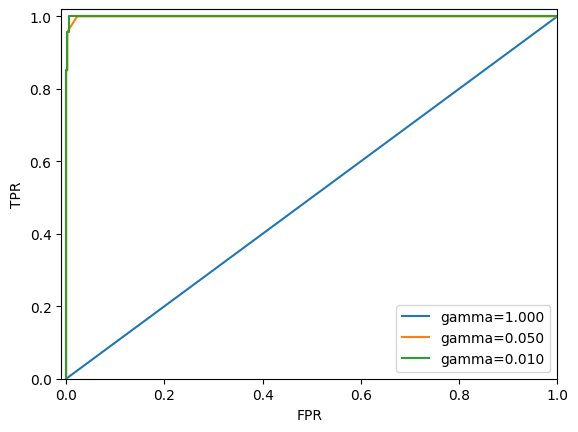

In [63]:
y = digits.target == 9
X_train, X_test, y_train, y_test = train_test_split(
    digits.data, y, random_state=0)

plt.figure()

for gamma in [1, 0.05, 0.01]:
    svc = SVC(gamma=gamma).fit(X_train, y_train)
    accuracy = svc.score(X_test, y_test)
    auc = roc_auc_score(y_test, svc.decision_function(X_test))
    fpr, tpr, _ = roc_curve(y_test, svc.decision_function(X_test))
    print("gamma = {:.2f}  accuracy = {:.2f}  AUC = {:.2f}".format(
        gamma, accuracy, auc))
    plt.plot(fpr, tpr, label="gamma={:.3f}".format(gamma))

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.xlim(-0.01, 1)
plt.ylim(0, 1.02)
plt.legend(loc="best")

The accuracy of all three settings of $\gamma$ is the same: 0.90. This is exactly the baseline rate of the majority class, meaning all three models might be predicting "not nine" for everything when you look at accuracy alone. But looking at the AUC and the corresponding curves, we see a dramatic distinction:

With $\gamma = 1.0$, the AUC is 0.50 -- literally at chance level, meaning the `decision_function` is as good as random. With $\gamma = 0.05$ and $\gamma = 0.01$, we get a perfect AUC of 1.0, meaning all positive points are ranked higher than all negative points. With the right threshold, these models can classify the data perfectly!

This is a striking example of why AUC is so important for imbalanced data: **accuracy told us all three models were equivalent; AUC revealed that one is useless and two are perfect.**

For this reason, we highly recommend using AUC when evaluating models on imbalanced data. Keep in mind that AUC does not make use of the default threshold, so adjusting the decision threshold might be necessary to obtain useful classification results from a model with a high AUC.

## Metrics for Multiclass Classification

Now that we have discussed evaluation of binary classification tasks in depth, let's move on to **multiclass classification**. Basically, all metrics for multiclass classification are derived from binary classification metrics, but averaged over all classes. Accuracy for multiclass classification is again defined as the fraction of correctly classified examples:

$$\text{Accuracy} = \frac{1}{n} \sum_{i=1}^{n} \mathbf{1}[\hat{y}_i = y_i]$$

And again, when classes are imbalanced, accuracy is not a great evaluation measure. Let's apply the confusion matrix and the classification report to the task of classifying the 10 different handwritten digits:

In [64]:
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(
    digits.data, digits.target, random_state=0)
lr = LogisticRegression(max_iter=5000).fit(X_train, y_train)
pred = lr.predict(X_test)
print("Accuracy: {:.3f}".format(accuracy_score(y_test, pred)))
print("Confusion matrix:\n{}".format(confusion_matrix(y_test, pred)))

Accuracy: 0.953
Confusion matrix:
[[37  0  0  0  0  0  0  0  0  0]
 [ 0 40  0  0  0  0  0  0  2  1]
 [ 0  0 41  3  0  0  0  0  0  0]
 [ 0  0  0 43  0  0  0  0  1  1]
 [ 0  0  0  0 37  0  0  1  0  0]
 [ 0  0  0  0  0 46  0  0  0  2]
 [ 0  1  0  0  0  0 51  0  0  0]
 [ 0  0  0  1  1  0  0 46  0  0]
 [ 0  3  1  0  0  0  0  0 43  1]
 [ 0  0  0  0  0  1  0  0  1 45]]


The model has an accuracy of 95.3%, which already tells us we are doing well. The confusion matrix provides more detail. Each row corresponds to a true label, and each column to a predicted label. Let's visualize it as a heatmap:

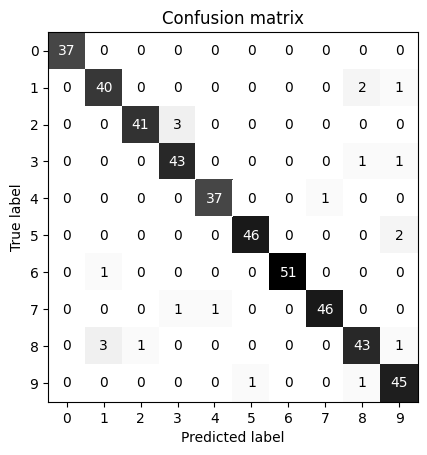

In [65]:
scores_image = mglearn.tools.heatmap(
    confusion_matrix(y_test, pred), xlabel='Predicted label',
    ylabel='True label', xticklabels=digits.target_names,
    yticklabels=digits.target_names, cmap=plt.cm.gray_r, fmt="%d")
plt.title("Confusion matrix")
plt.gca().invert_yaxis()

For the first class (digit 0), all 37 samples were correctly classified -- there are no false negatives and no false positives for class 0. Some digits were confused with others, though: for example, 3 instances of digit 2 were misclassified as digit 3, and 3 instances of digit 8 were misclassified as digit 1.

With the `classification_report` function, we can compute the precision, recall, and $F_1$-score for each class:

In [66]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       0.91      0.93      0.92        43
           2       0.98      0.93      0.95        44
           3       0.91      0.96      0.93        45
           4       0.97      0.97      0.97        38
           5       0.98      0.96      0.97        48
           6       1.00      0.98      0.99        52
           7       0.98      0.96      0.97        48
           8       0.91      0.90      0.91        48
           9       0.90      0.96      0.93        47

    accuracy                           0.95       450
   macro avg       0.95      0.95      0.95       450
weighted avg       0.95      0.95      0.95       450



Precision and recall are a perfect 1.00 for class 0, as there are no confusions. For class 8, precision is only 0.91, and for class 9 precision is 0.90, indicating these are the most commonly confused digits.

The most commonly used metric for imbalanced datasets in the multiclass setting is the multiclass version of the $F_1$-score. The idea is to compute one binary $F_1$ per class, then average using one of these strategies:

**"macro" averaging** computes the unweighted mean of per-class $F_1$-scores, giving equal weight to all classes regardless of size:

$$F_1^{\text{macro}} = \frac{1}{K} \sum_{c=1}^{K} F_1^{(c)}$$

**"micro" averaging** computes the total TP, FP, and FN over all classes, then computes $F_1$ from those totals. For multiclass classification, micro-averaged $F_1$ equals accuracy:

$$F_1^{\text{micro}} = \frac{2 \cdot TP_{\text{total}}}{2 \cdot TP_{\text{total}} + FP_{\text{total}} + FN_{\text{total}}}$$

**"weighted" averaging** computes the mean of per-class $F_1$-scores, weighted by their support (number of samples):

$$F_1^{\text{weighted}} = \sum_{c=1}^{K} \frac{n_c}{n} \cdot F_1^{(c)}$$

If you care about each sample equally, use "micro"; if you care about each class equally, use "macro":

In [67]:
print("Micro average f1 score: {:.3f}".format(
    f1_score(y_test, pred, average="micro")))
print("Macro average f1 score: {:.3f}".format(
    f1_score(y_test, pred, average="macro")))

Micro average f1 score: 0.953
Macro average f1 score: 0.954


The micro and macro $F_1$-scores are nearly identical here (0.953 vs. 0.954), suggesting that the model performs similarly across all digit classes. In highly imbalanced multiclass problems, these numbers can differ significantly.

## Regression Metrics

Evaluation for regression can be done in similar detail as for classification. The most commonly used metrics are:

**$R^2$ (coefficient of determination)** -- the default in scikit-learn's `score` method:

$$R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}$$

**Mean Squared Error (MSE):**

$$\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$

**Mean Absolute Error (MAE):**

$$\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|$$

In general, $R^2$ is the most intuitive metric for regression, as it measures the proportion of variance explained by the model (1.0 = perfect, 0.0 = no better than predicting the mean). MSE and MAE are useful when business decisions are made in units of the target variable (e.g., dollars).

## Using Evaluation Metrics in Model Selection

We have discussed many evaluation methods in detail. However, we often want to use metrics like AUC in model selection using `GridSearchCV` or `cross_val_score`. Luckily, scikit-learn provides a simple way to achieve this via the **`scoring` argument**. You can provide a string describing the evaluation metric. For example, changing the score from accuracy to AUC can be done by providing `"roc_auc"` as the `scoring` parameter:

In [68]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

# default scoring for classification is accuracy
print("Default scoring: {}".format(
    cross_val_score(SVC(), digits.data, digits.target == 9)))
# providing scoring="accuracy" doesn't change the results
explicit_accuracy = cross_val_score(SVC(), digits.data, digits.target == 9,
                                    scoring="accuracy")
print("Explicit accuracy scoring: {}".format(explicit_accuracy))
roc_auc = cross_val_score(SVC(), digits.data, digits.target == 9,
                          scoring="roc_auc")
print("AUC scoring: {}".format(roc_auc))

Default scoring: [0.975      0.99166667 1.         0.99442897 0.98050139]
Explicit accuracy scoring: [0.975      0.99166667 1.         0.99442897 0.98050139]
AUC scoring: [0.99717078 0.99854252 1.         0.999828   0.98400413]


The accuracy scores are high (0.975 to 1.0), but the AUC scores are even higher (0.984 to 1.0), reflecting the fact that AUC evaluates the ranking quality of the `decision_function`, not just the binary predictions.

Similarly, we can change the metric used to pick the best parameters in `GridSearchCV`. This is where the choice of metric can have a significant impact:

In [69]:
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(
    digits.data, digits.target == 9, random_state=0)

# we provide a somewhat bad grid to illustrate the point:
param_grid = {'gamma': [0.0001, 0.01, 0.1, 1, 10]}

# using the default scoring of accuracy:
grid = GridSearchCV(SVC(), param_grid=param_grid)
grid.fit(X_train, y_train)
print("Grid-Search with accuracy")
print("Best parameters:", grid.best_params_)
print("Best cross-validation score (accuracy): {:.3f}".format(grid.best_score_))
print("Test set AUC: {:.3f}".format(
    roc_auc_score(y_test, grid.decision_function(X_test))))
print("Test set accuracy: {:.3f}".format(grid.score(X_test, y_test)))

Grid-Search with accuracy
Best parameters: {'gamma': 0.0001}
Best cross-validation score (accuracy): 0.976
Test set AUC: 0.992
Test set accuracy: 0.973


In [70]:
# using AUC scoring instead:
grid = GridSearchCV(SVC(), param_grid=param_grid, scoring="roc_auc")
grid.fit(X_train, y_train)
print("Grid-Search with AUC")
print("Best parameters:", grid.best_params_)
print("Best cross-validation score (AUC): {:.3f}".format(grid.best_score_))
print("Test set AUC: {:.3f}".format(
    roc_auc_score(y_test, grid.decision_function(X_test))))
print("Test set accuracy: {:.3f}".format(grid.score(X_test, y_test)))

Grid-Search with AUC
Best parameters: {'gamma': 0.01}
Best cross-validation score (AUC): 0.998
Test set AUC: 1.000
Test set accuracy: 1.000


When using accuracy, the parameter $\gamma = 0.0001$ is selected, while $\gamma = 0.01$ is selected when using AUC. Using AUC found a better parameter setting -- not just in terms of AUC (test AUC = 1.000 vs. 0.992), but even in terms of accuracy (test accuracy = 1.000 vs. 0.973)! This demonstrates a crucial point: **using the right evaluation metric for model selection can lead to better models even when evaluated by other metrics**.

The most important values for the `scoring` parameter for classification are: `accuracy` (the default), `roc_auc` for the area under the ROC curve, `average_precision` for the area under the precision-recall curve, and `f1`, `f1_macro`, `f1_micro`, `f1_weighted` for the binary $F_1$-score and its multiclass variants. For regression, the most commonly used values are `r2` for the $R^2$ score, `neg_mean_squared_error` for MSE, and `neg_mean_absolute_error` for MAE (note the `neg_` prefix: scikit-learn negates these so that higher is always better).

You can find a full list of supported arguments:

In [71]:
from sklearn.metrics import get_scorer_names
print("Available scorers:\n{}".format(sorted(get_scorer_names())))

Available scorers:
['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'd2_absolute_error_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'matthews_corrcoef', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_max_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_negative_likelihood_ratio', 'neg_root_mean_squared_error', 'neg_root_mean_squared_log_error', 'normalized_mutual_info_score', 'positive_likelihood_ratio', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'rand_score', 'recall', 'recall_macro', 'recall_micro

## Summary and Outlook

In this chapter we discussed cross-validation, grid search, and evaluation metrics, the cornerstones of evaluating and improving machine learning algorithms. Two points warrant repeating:

**First, on cross-validation and data leakage:** Cross-validation or the use of a test set allow us to evaluate a machine learning model as it will perform in the future. However, if we use the test set or cross-validation to select a model or select model parameters, we "use up" the test data. Any choices made based on the test set accuracy "leak" information from the test set into the model. We therefore need to resort to:

$$\text{Data} \rightarrow \underbrace{\text{Training}}_{\text{build model}} + \underbrace{\text{Validation}}_{\text{select params}} + \underbrace{\text{Test}}_{\text{final evaluation}}$$

or replace these splits with nested cross-validation.

**Second, on evaluation metrics:** It is rarely the case that the end goal of a machine learning task is building a model with high accuracy alone. In reality, classification problems rarely have balanced classes, and often false positives and false negatives have very different consequences. The key formulas to remember are:

$$\text{Precision} = \frac{TP}{TP + FP}, \quad \text{Recall} = \frac{TP}{TP + FN}, \quad F_1 = 2 \cdot \frac{P \cdot R}{P + R}$$

$$\text{AUC} = P(f(x^+) > f(x^-)), \quad \text{FPR} = \frac{FP}{FP + TN}$$

Make sure the metric you choose to evaluate and select a model is a good stand-in for what the model will actually be used for. Using the right metric (like AUC instead of accuracy for imbalanced data) can be the difference between selecting a useless model and a perfect one, as we saw in the $\gamma$ comparison example.

In the next chapter, we will introduce the `Pipeline` class, which allows us to use grid search and cross-validation on complex chains of algorithms that combine preprocessing and modeling.